# eBOSS QSO Multipoles with Redshift Weights

Updated: 9/20/17

### Data

- eBOSS QSO catalog, version ``v1.9f``
- trimmed to redshift range $0.5 < z < 2.5$
- within this range, $N^\mathrm{NGC} = 106832$, $N^\mathrm{SGC} = 71256$
- sky area: $A^\mathrm{NGC} = 1214.6456 \ \mathrm{deg}^2$,  $A^\mathrm{SGC} = 898.27440 \ \mathrm{deg}^2$

### Measurement

We measure the cross-correlation of the unweighted density field, with a redshift-weighted density field:

$$
P(k) \sim \langle \delta_0 \widetilde{\delta}_\ell \rangle
$$
where $\delta_0$ is the unweighted density field, and the weighted density field $\widetilde{\delta}_\ell$ is weighted based on the value of $\ell$. The monopole weights are given by:

$$
w_0(z) = \left[ b_\mathrm{QSO}(z) + f/3 \right] \times \left[ b_\mathrm{QSO}(z) - 1.6 \right]  D(z),
$$
and the quadrupole weights are given by:

$$
w_2(z) = 4/3 f \left[ b_\mathrm{QSO} - 1.6 \right] D(z).
$$

The bias model used is taken from [1705.04718](https://arxiv.org/abs/1705.04718), $D(z)$ is the linear growth factor, and $f(z)$ is the linear growth rate, given by $f = d\mathrm{ln}D / d\mathrm{ln}z$.


We also apply FKP weights using $P_0^\mathrm{FKP} = 30,000 \ h^{-3} \mathrm{Mpc}^3$.

### Normalization and Shot Noise

For the weighted cross correlation we compute the normalization as:

$$
A = \int \bar{n}_1(z) \bar{n}_2(z) w_1(z) w_2(z) d^3x \approx \sum_\mathrm{gals} \bar{n}_2 w_1 w_2.
$$

This assumes $\bar{n}_1 = \bar{n}_2$. The weights are a function of redshift. In the unweighted case, $w_1(z) = w^\mathrm{FKP}(z)$ and in the redshift-weighted case, we have $w_2(z) = w^\mathrm{FKP}(z) w_\ell(z)$.

The shot noise is computed as:

$$
S = \int \bar{n}_1(z) w_1(z) w_2(z) d^3x \approx A^{-1} \sum_\mathrm{gals} w_1 w_2.
$$

This is taken largely from Appendix A of [1309.5556](https://arxiv.org/abs/1309.5556) for cross correlations.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import style, setup_logging

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

## Weighting Functions

In [25]:
# the fiducial DR12 cosmology
h = 0.676
Ob0 = 0.022/h**2
Ocdm0 = 0.31 - Ob0
cosmo = cosmology.Cosmology(h=h, m_ncdm=None, T_cmb=2.7255, Omega_b=Ob0, Omega_cdm=Ocdm0)

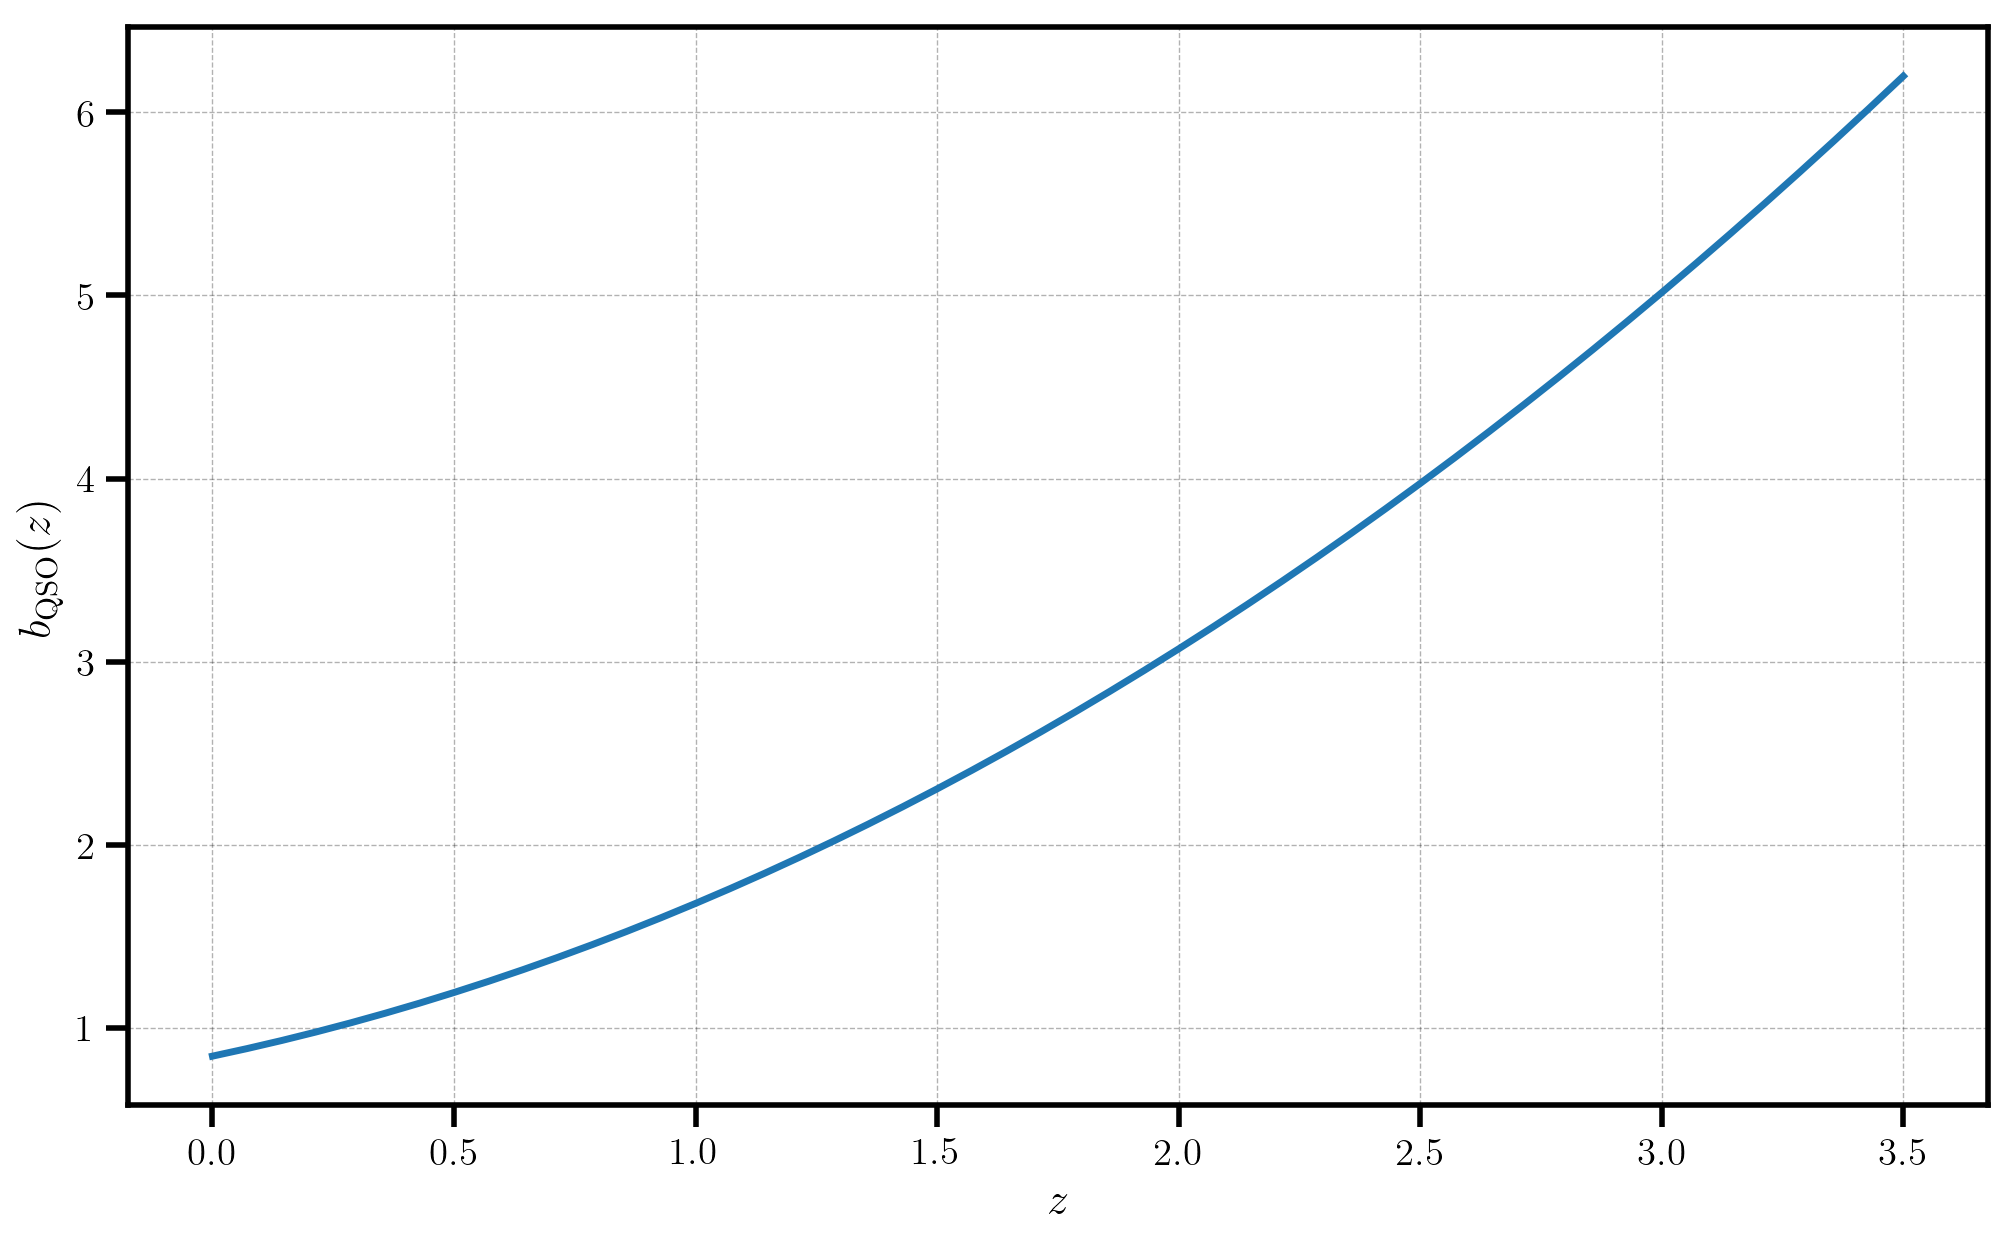

In [32]:
def bias_model(z):
    """
    QSO bias model taken from Laurent et al. 2016 (1705.04718)
    """
    alpha = 0.278
    beta = 2.393
    return alpha * ( (1+z)**2 - 6.565 ) + beta

z = numpy.linspace(0, 3.5)
plt.plot(z, bias_model(z))
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$b_\mathrm{QSO}(z)$", fontsize=16)

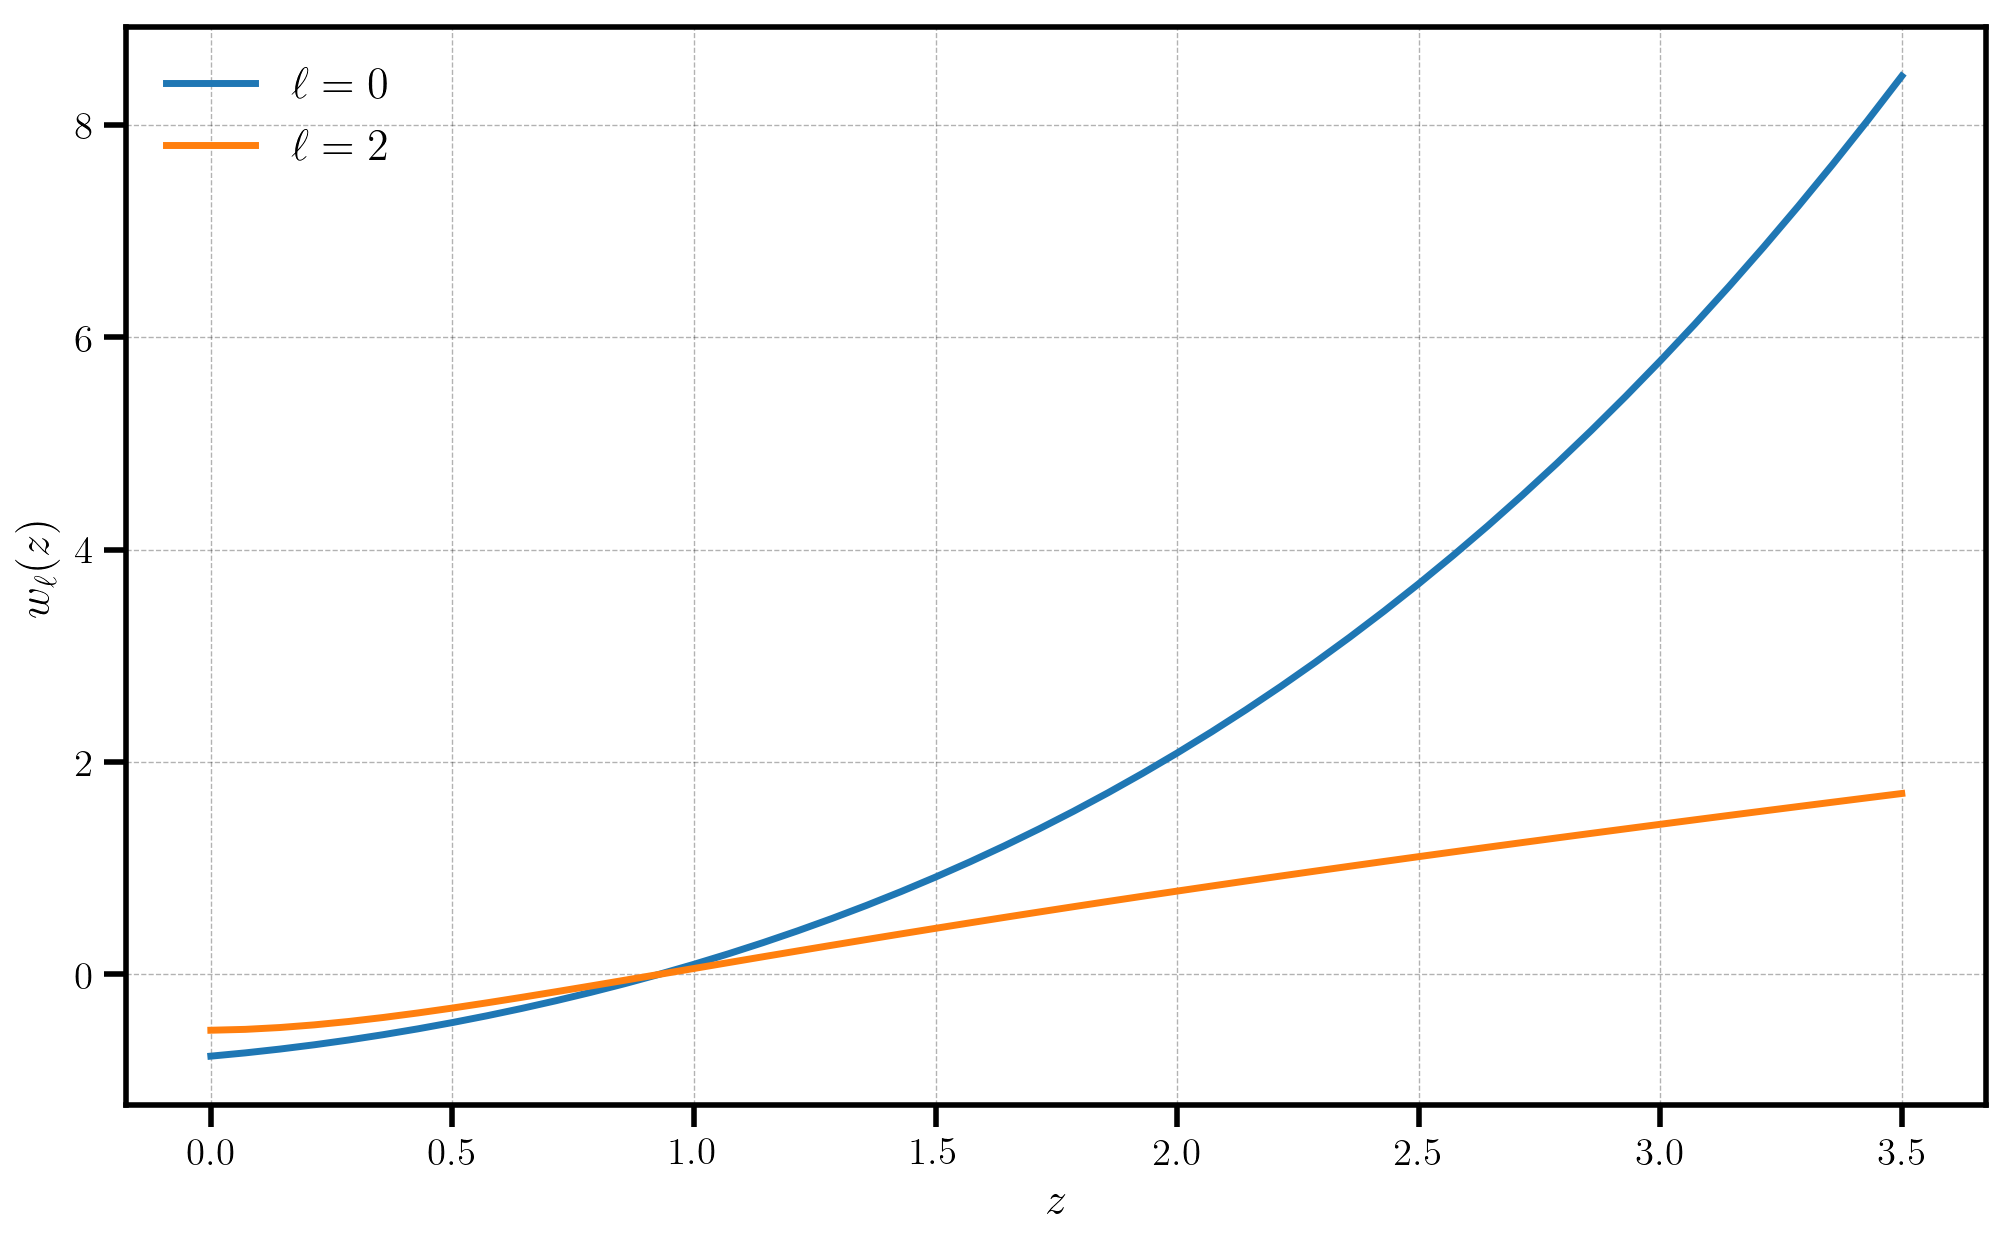

In [30]:
def redshift_weight(z, ell):
    """
    Apply the redshift weighting for the specific multipole ``ell``
    """
    p = 1.6
    b = bias_model(z)
    D = cosmo.scale_independent_growth_factor(z)
    f = cosmo.scale_independent_growth_rate(z)

    w = 1.0
    if ell == 0:
        w = (b + f/3.)*(b-p)*D
    elif ell == 2:
        w = 4./3*f*(b-p)*D
    return w

plt.plot(z, redshift_weight(z, ell=0), label=r'$\ell=0$')
plt.plot(z, redshift_weight(z, ell=2), label=r'$\ell=2$')
plt.legend(loc=0)
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$w_\ell(z)$", fontsize=16)

## Redshift Distribution of Data Catalog

In [20]:
# load the data catalogs
ngc = FITSCatalog('../Data/eboss_v1.9f-QSO-N-eboss_v1.9f.dat.fits')
sgc = FITSCatalog('../Data/eboss_v1.9f-QSO-S-eboss_v1.9f.dat.fits')

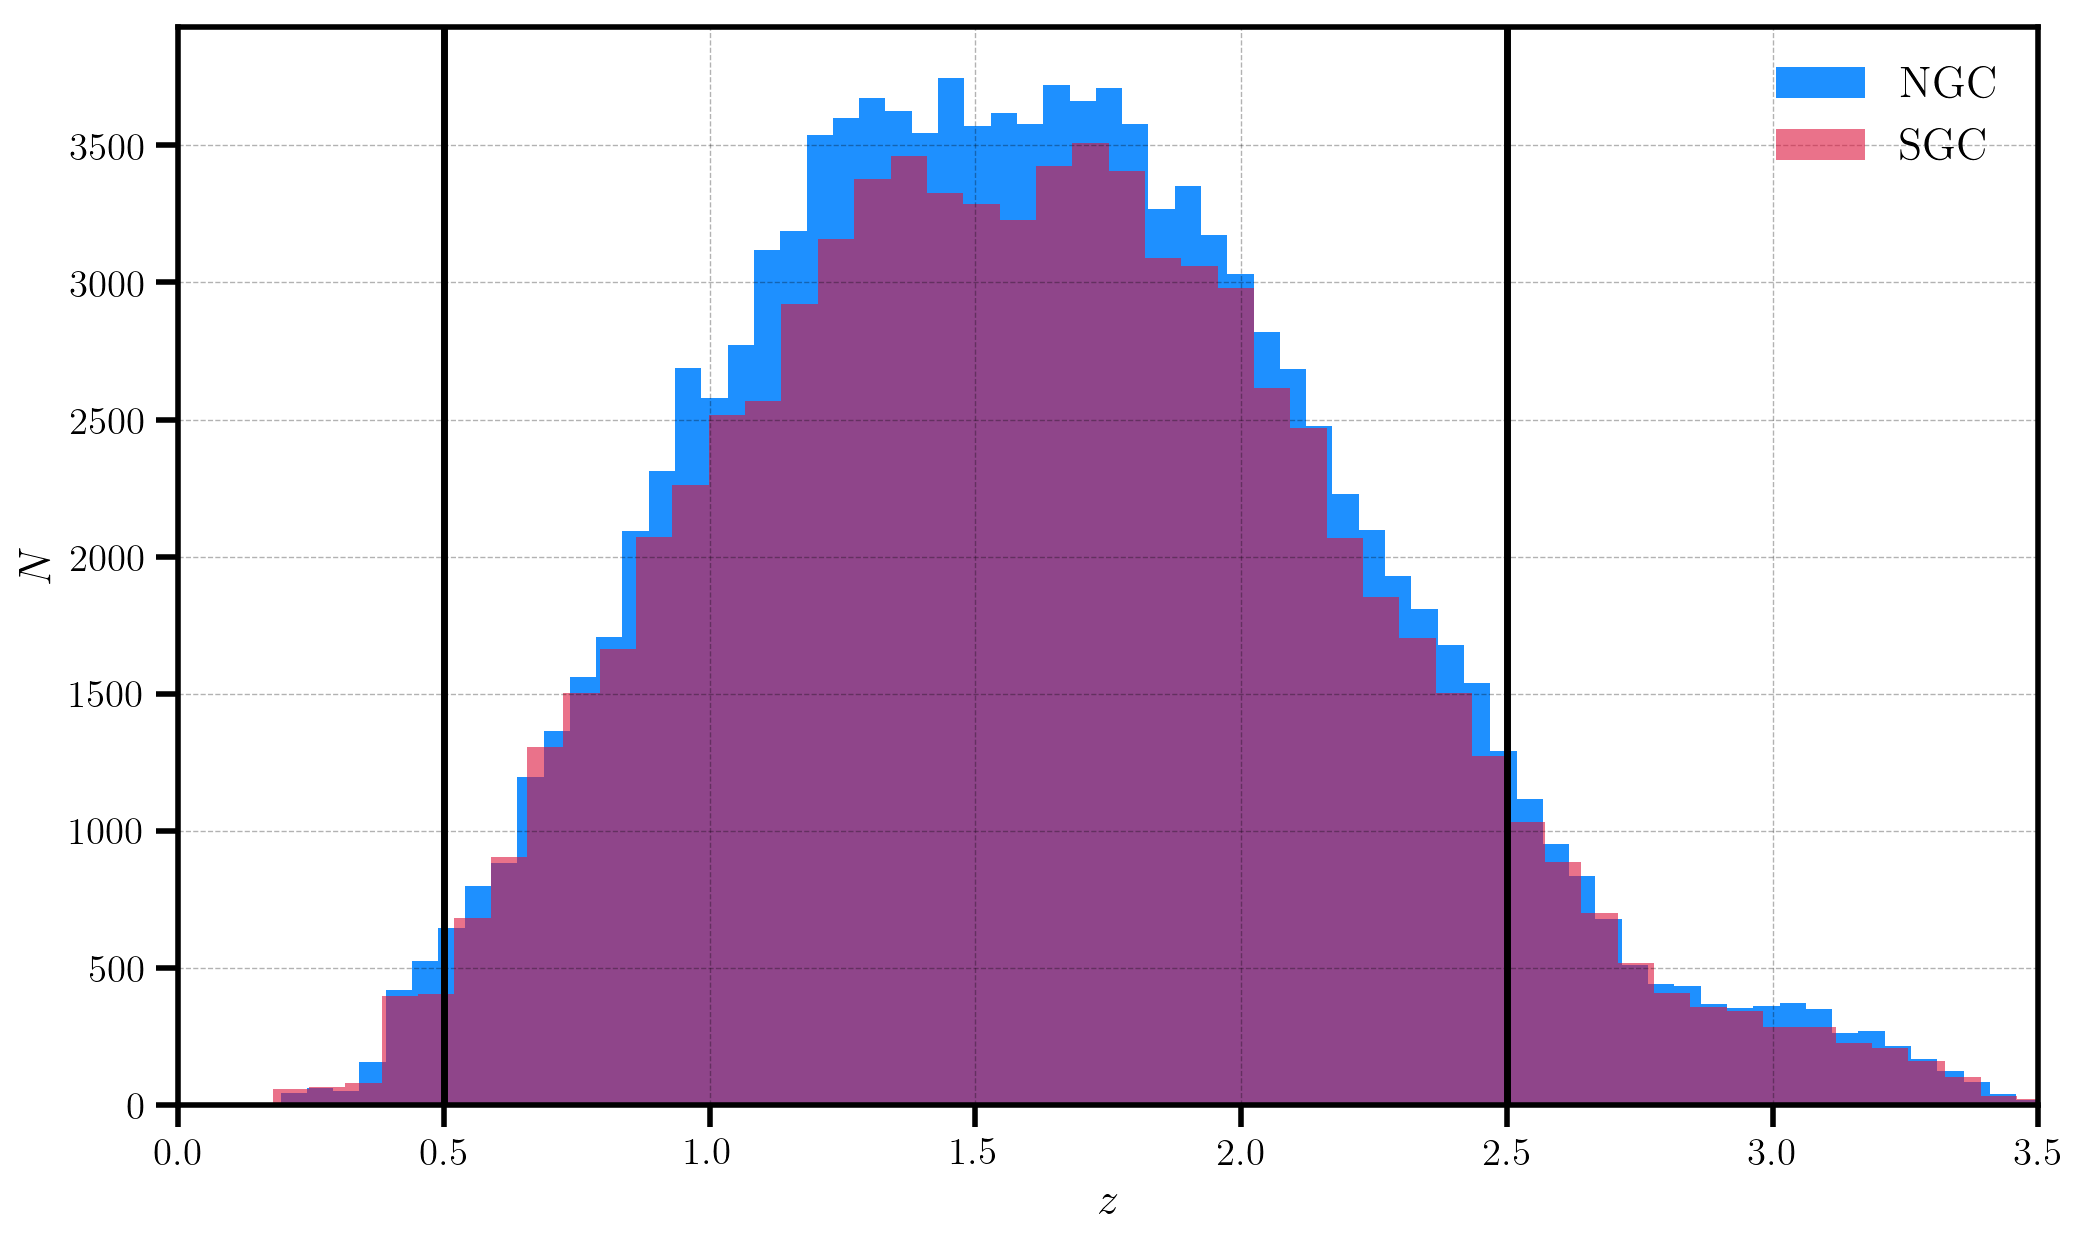

In [24]:
plt.hist(ngc['Z'].compute(), bins=100, facecolor='DodgerBlue', label='NGC')
plt.hist(sgc['Z'].compute(), bins=100, facecolor='Crimson', label='SGC', alpha=0.6)

plt.legend(loc=0)
plt.xlim(0, 3.5)
plt.axvline(x=0.5, c='k')
plt.axvline(x=2.5, c='k')
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$N$", fontsize=16)

## Measured Multipole Results

### North Galactic Cap

In [16]:
# load the NGC results

no_weights_N = ConvolvedFFTPower.load('../Results/poles_eboss_v1.9f-QSO-N_dk005_kmin0_0.5-2.5_no_z_weights.json')
P0_weights_N = ConvolvedFFTPower.load('../Results/poles_eboss_v1.9f-QSO-N_dk005_kmin0_0.5-2.5_cross_z_weights_P0.json')
P2_weights_N = ConvolvedFFTPower.load('../Results/poles_eboss_v1.9f-QSO-N_dk005_kmin0_0.5-2.5_cross_z_weights_P2.json')

(100, 200000.0)

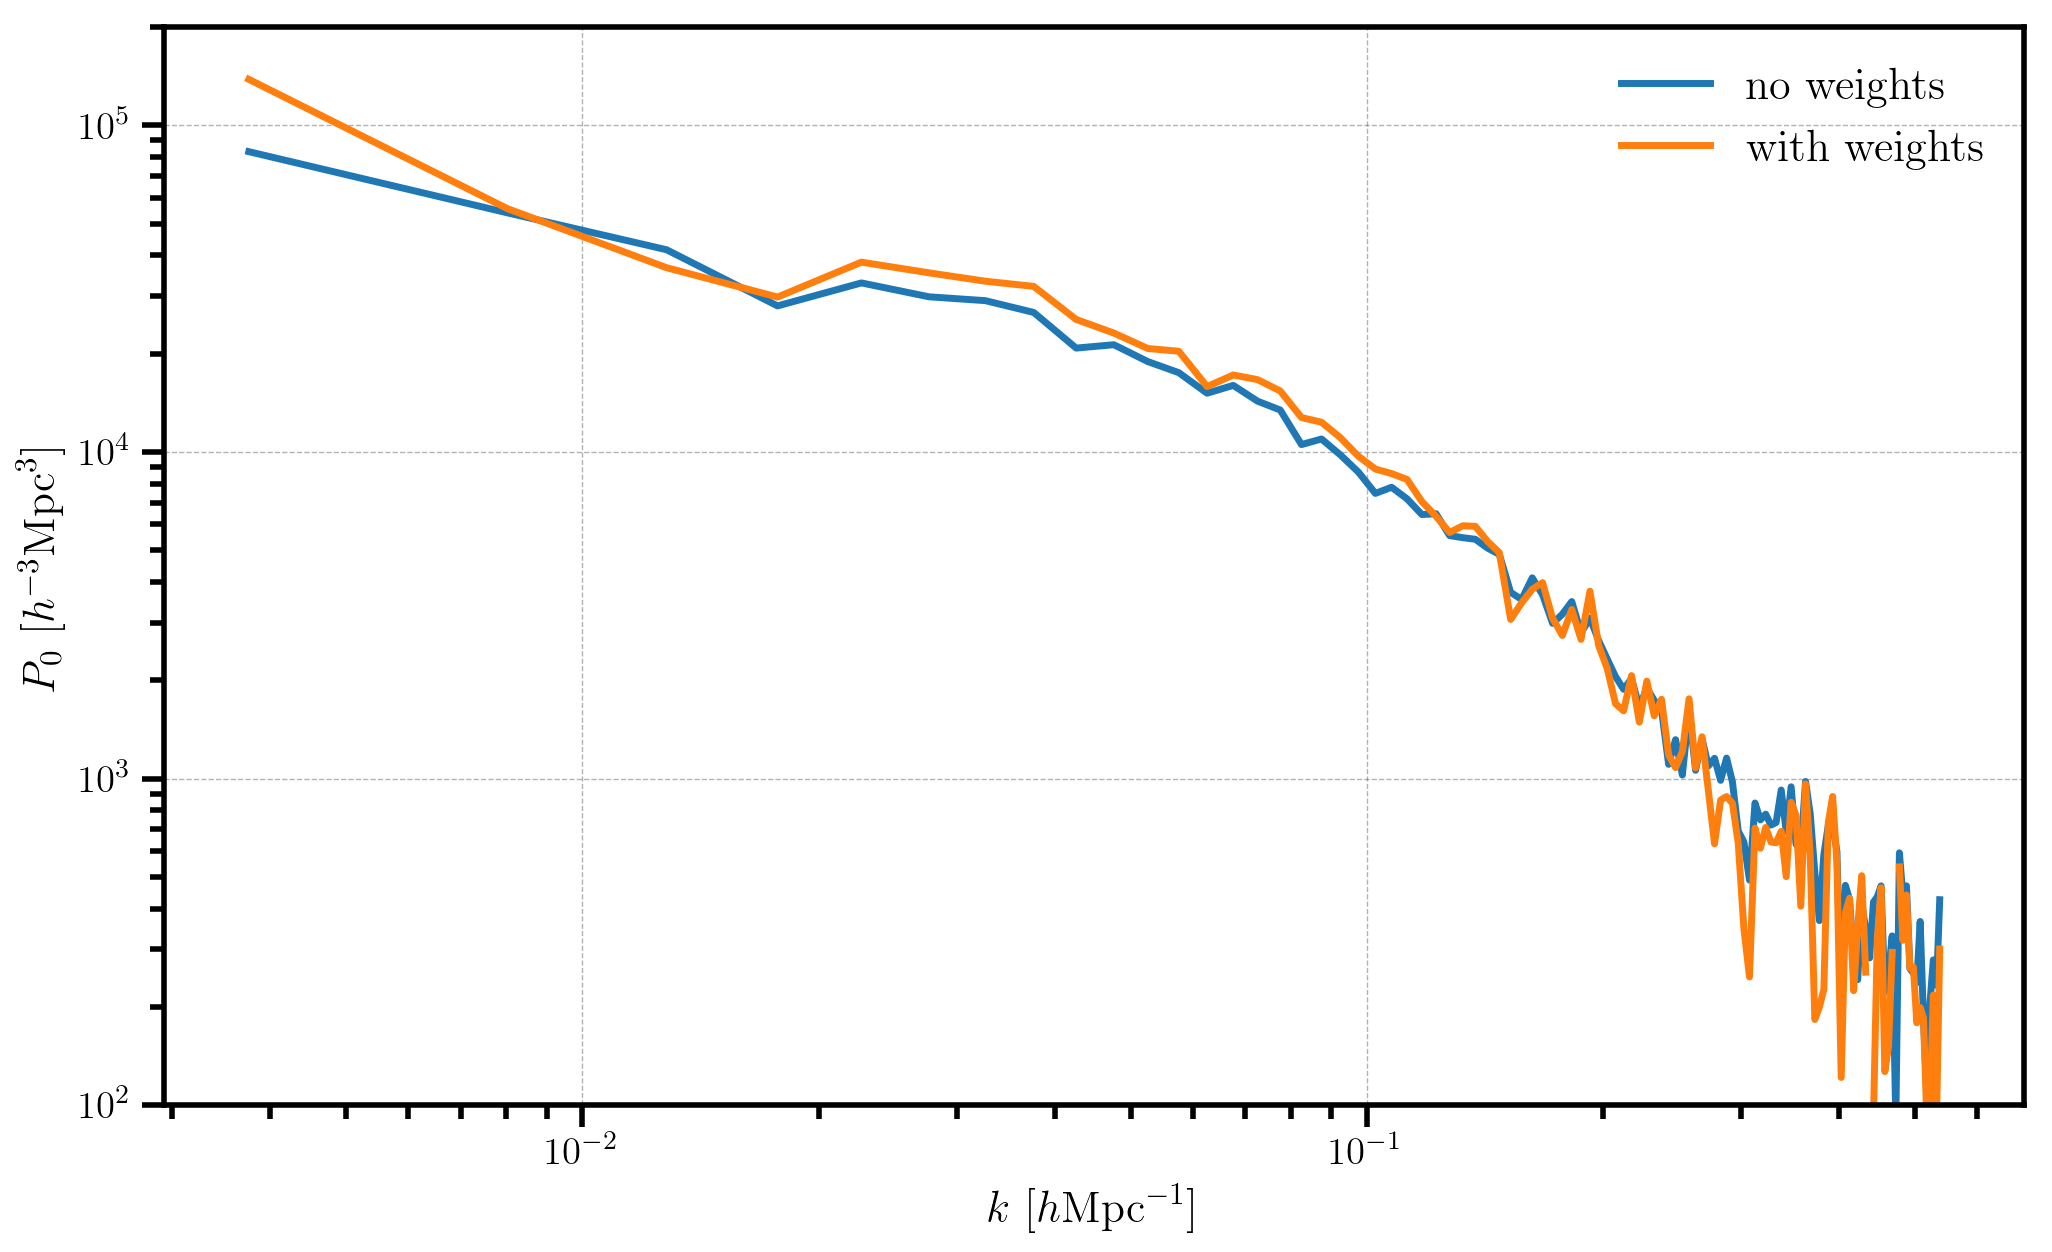

In [17]:
# Monopole

labels = ['no weights', 'with weights']
for i, r in enumerate([no_weights_N, P0_weights_N]):
    
    x = r.poles
    plt.loglog(x['k'], x['power_0'].real - r.attrs['shotnoise'], label=labels[i])
    
plt.legend(loc=0)
plt.xlabel(r'$k$ [$h \mathrm{Mpc}^{-1}$]', fontsize=16)
plt.ylabel(r'$P_0$ [$h^{-3} \mathrm{Mpc}^3$]', fontsize=16)
plt.ylim(100, 2e5)

Measured monopole from the NGC eBOSS sample with (orange) and without (blue) redshift weights.

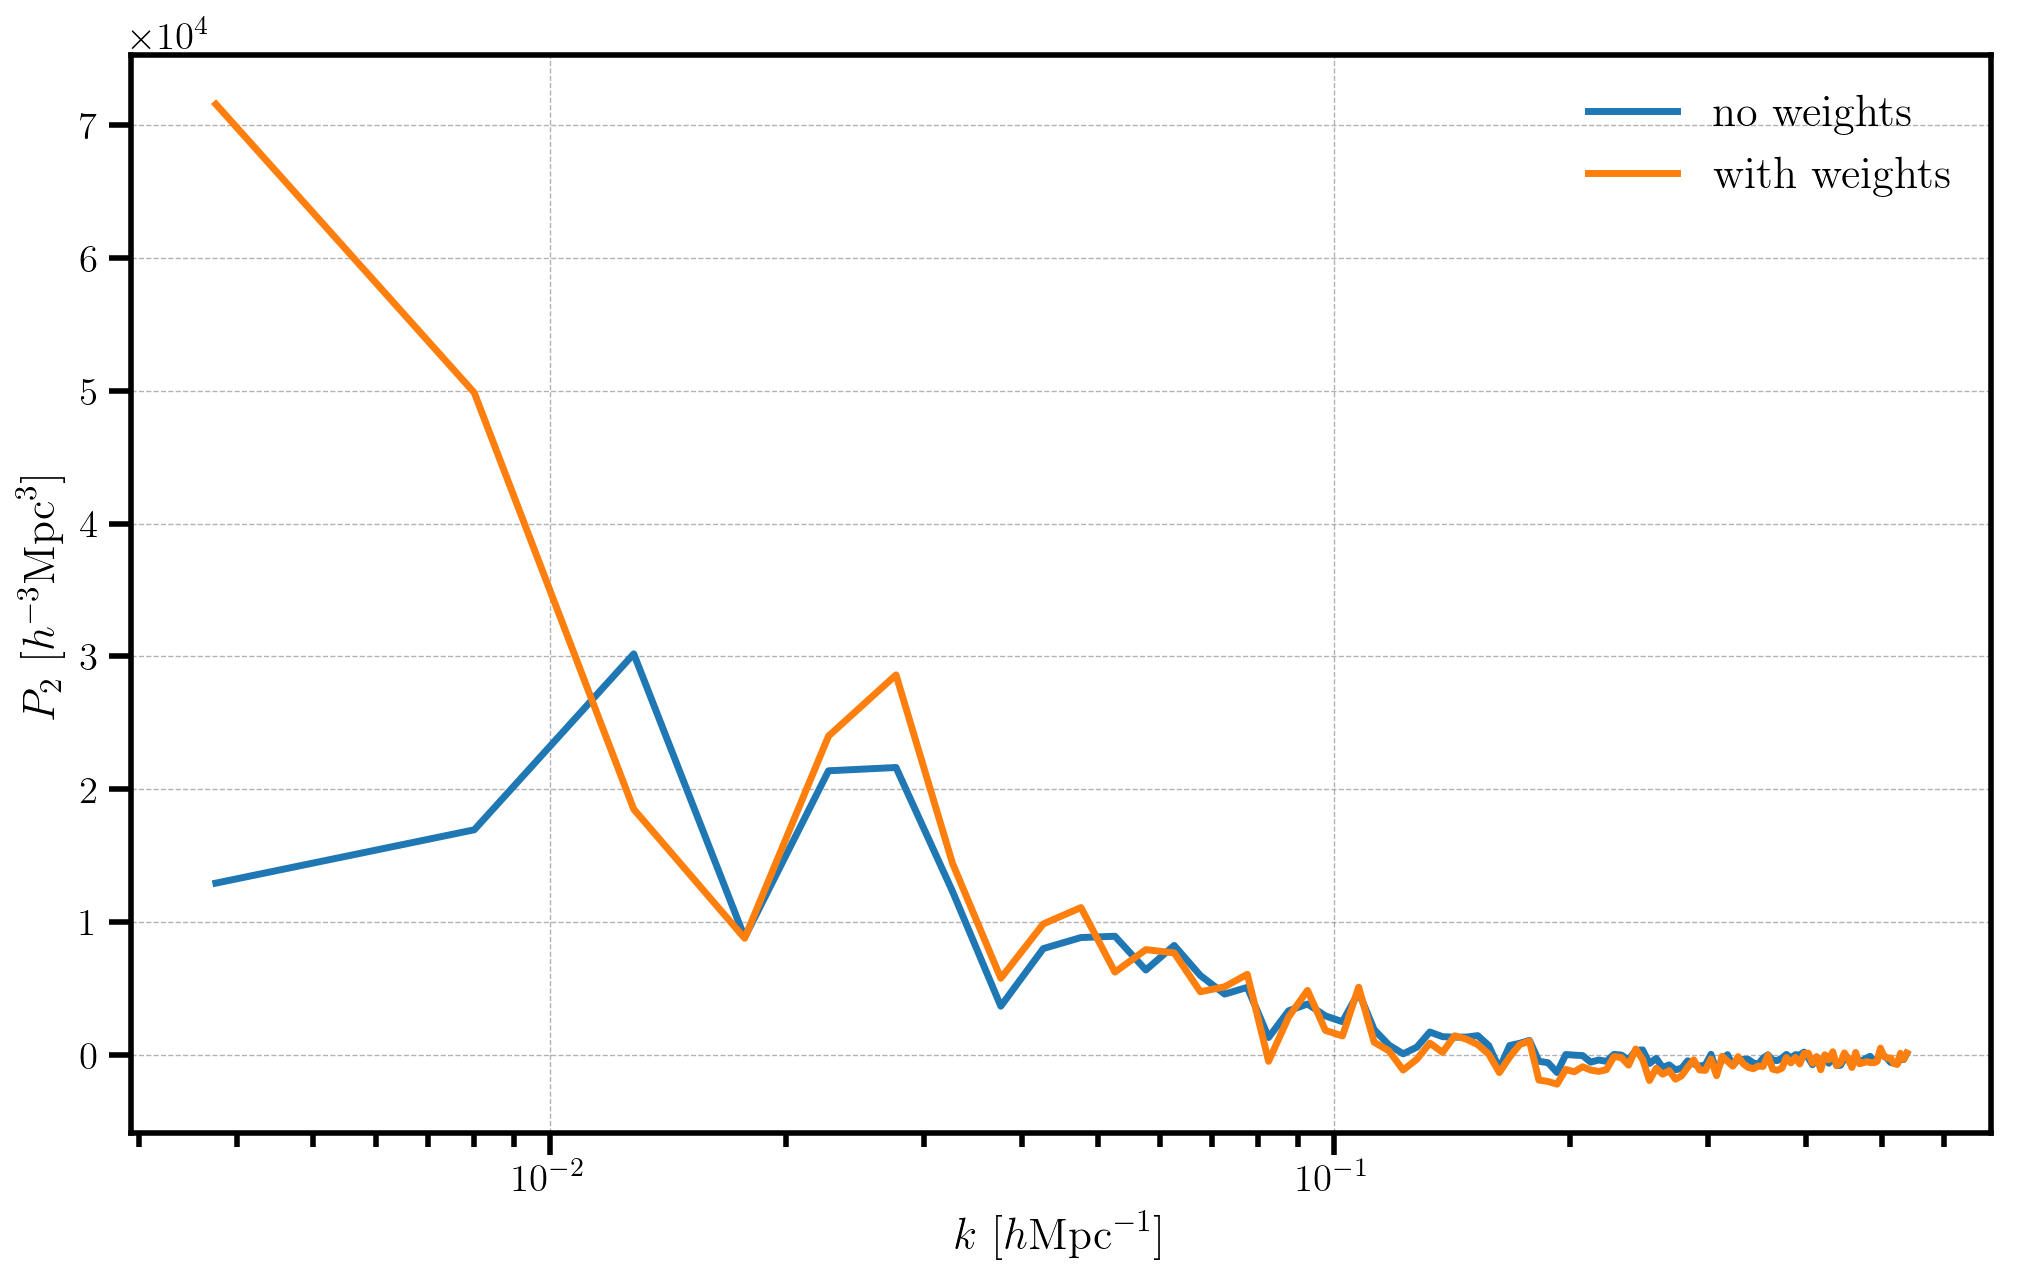

In [10]:
# Quadrupole

labels = ['no weights', 'with weights']
for i, r in enumerate([no_weights_N, P2_weights_N]):
    
    x = r.poles
    plt.semilogx(x['k'], x['power_2'].real, label=labels[i])
    
plt.legend(loc=0)
plt.xlabel(r'$k$ [$h \mathrm{Mpc}^{-1}$]', fontsize=16)
plt.ylabel(r'$P_2$ [$h^{-3} \mathrm{Mpc}^3$]', fontsize=16)

Measured quadrupole from the NGC eBOSS sample with (orange) and without (blue) redshift weights.

### South Galactic Cap


In [12]:
# load the SGC results

no_weights_S = ConvolvedFFTPower.load('../Results/poles_eboss_v1.9f-QSO-S_dk005_kmin0_0.5-2.5_no_z_weights.json')
P0_weights_S = ConvolvedFFTPower.load('../Results/poles_eboss_v1.9f-QSO-S_dk005_kmin0_0.5-2.5_cross_z_weights_P0.json')
P2_weights_S = ConvolvedFFTPower.load('../Results/poles_eboss_v1.9f-QSO-S_dk005_kmin0_0.5-2.5_cross_z_weights_P2.json')

(100, 200000.0)

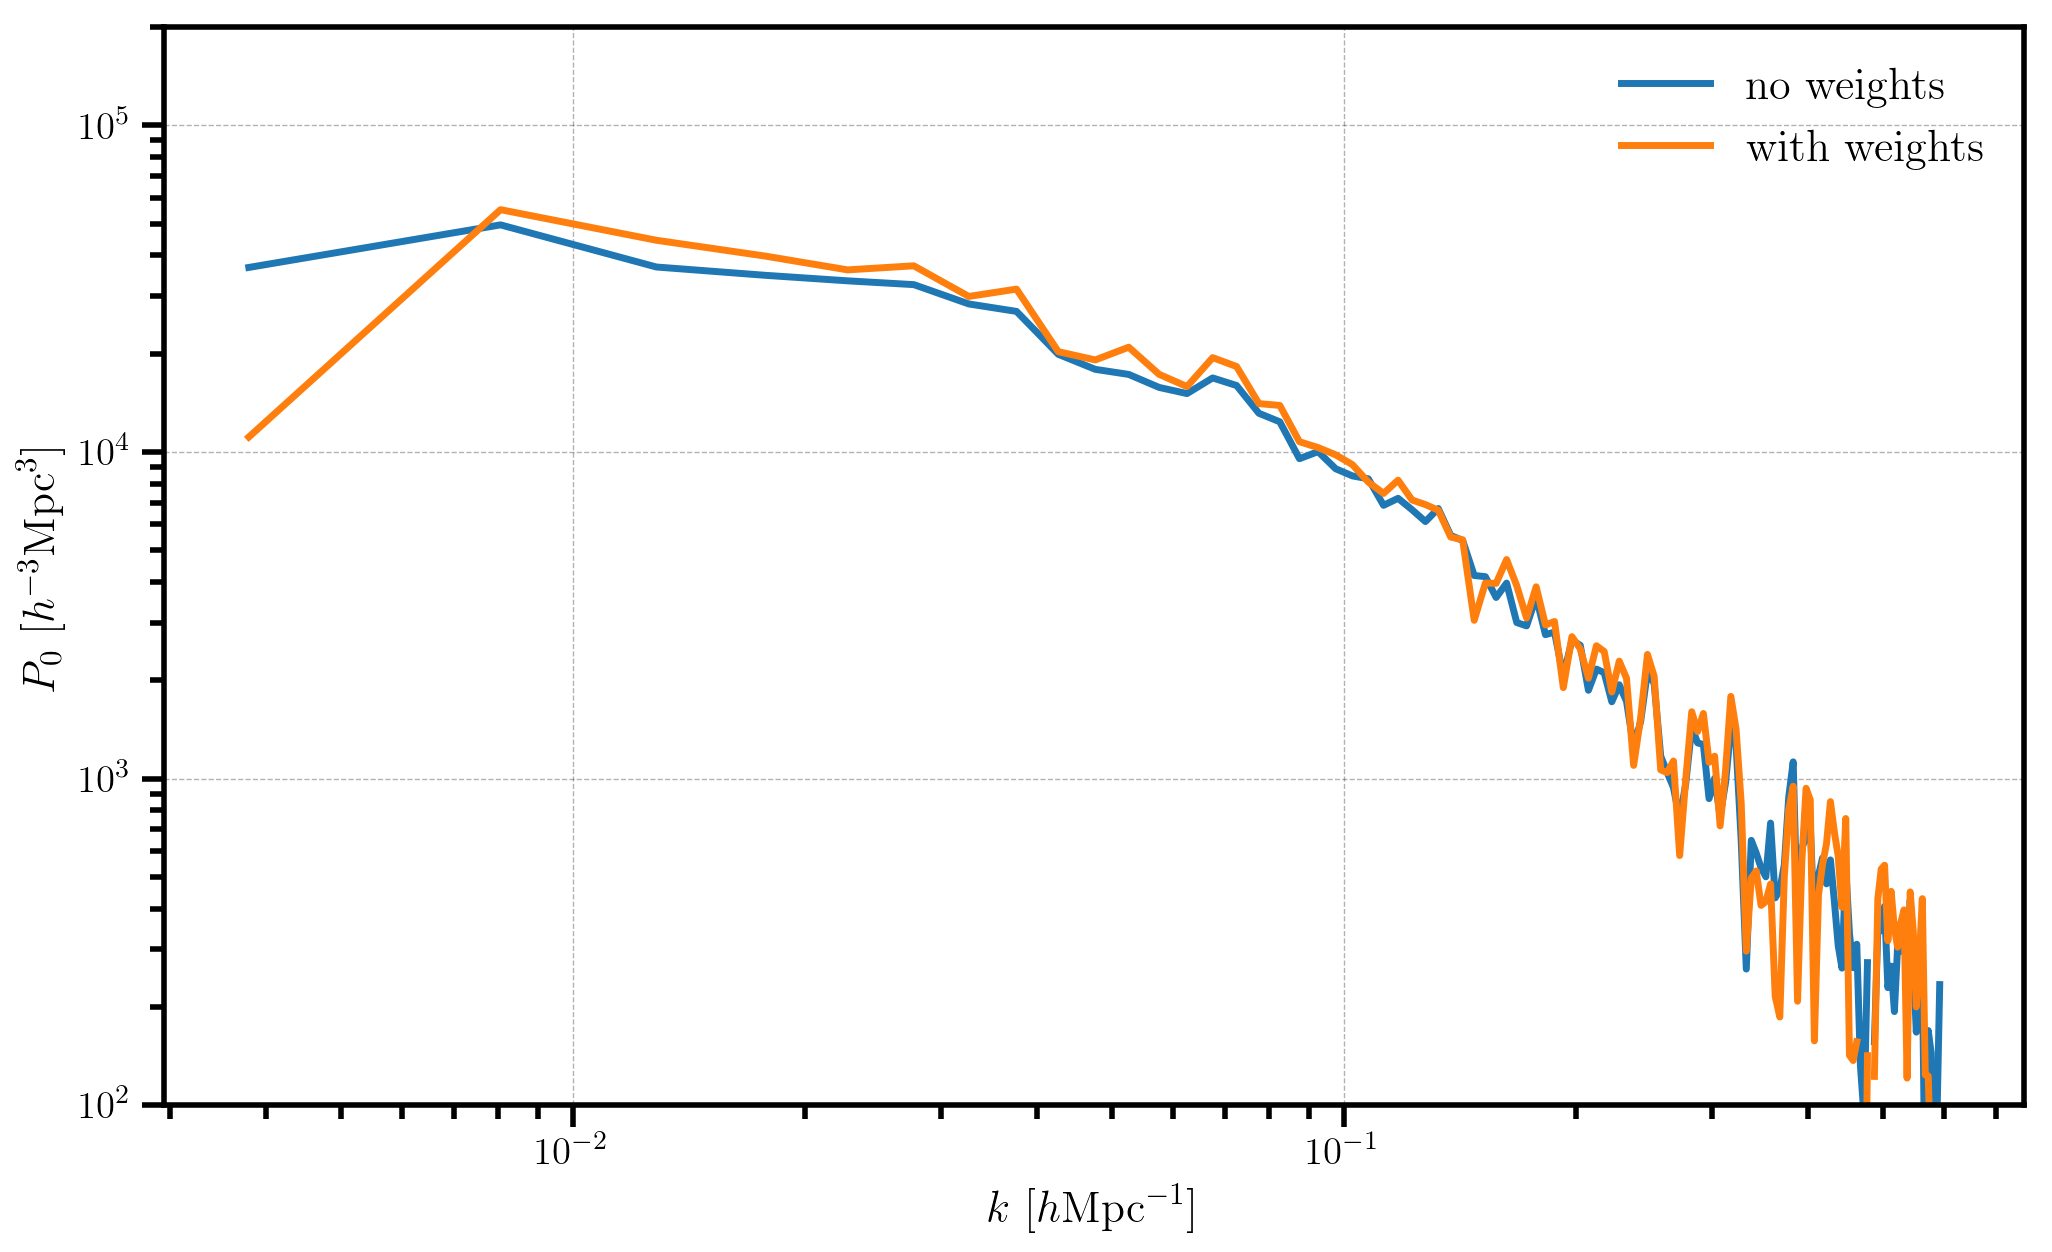

In [14]:
# Monopole

labels = ['no weights', 'with weights']
for i, r in enumerate([no_weights_S, P0_weights_S]):
    
    x = r.poles
    plt.loglog(x['k'], x['power_0'].real - r.attrs['shotnoise'], label=labels[i])
    
plt.legend(loc=0)
plt.xlabel(r'$k$ [$h \mathrm{Mpc}^{-1}$]', fontsize=16)
plt.ylabel(r'$P_0$ [$h^{-3} \mathrm{Mpc}^3$]', fontsize=16)
plt.ylim(1e2, 2e5)

Measured monopole from the SGC eBOSS sample with (orange) and without (blue) redshift weights.

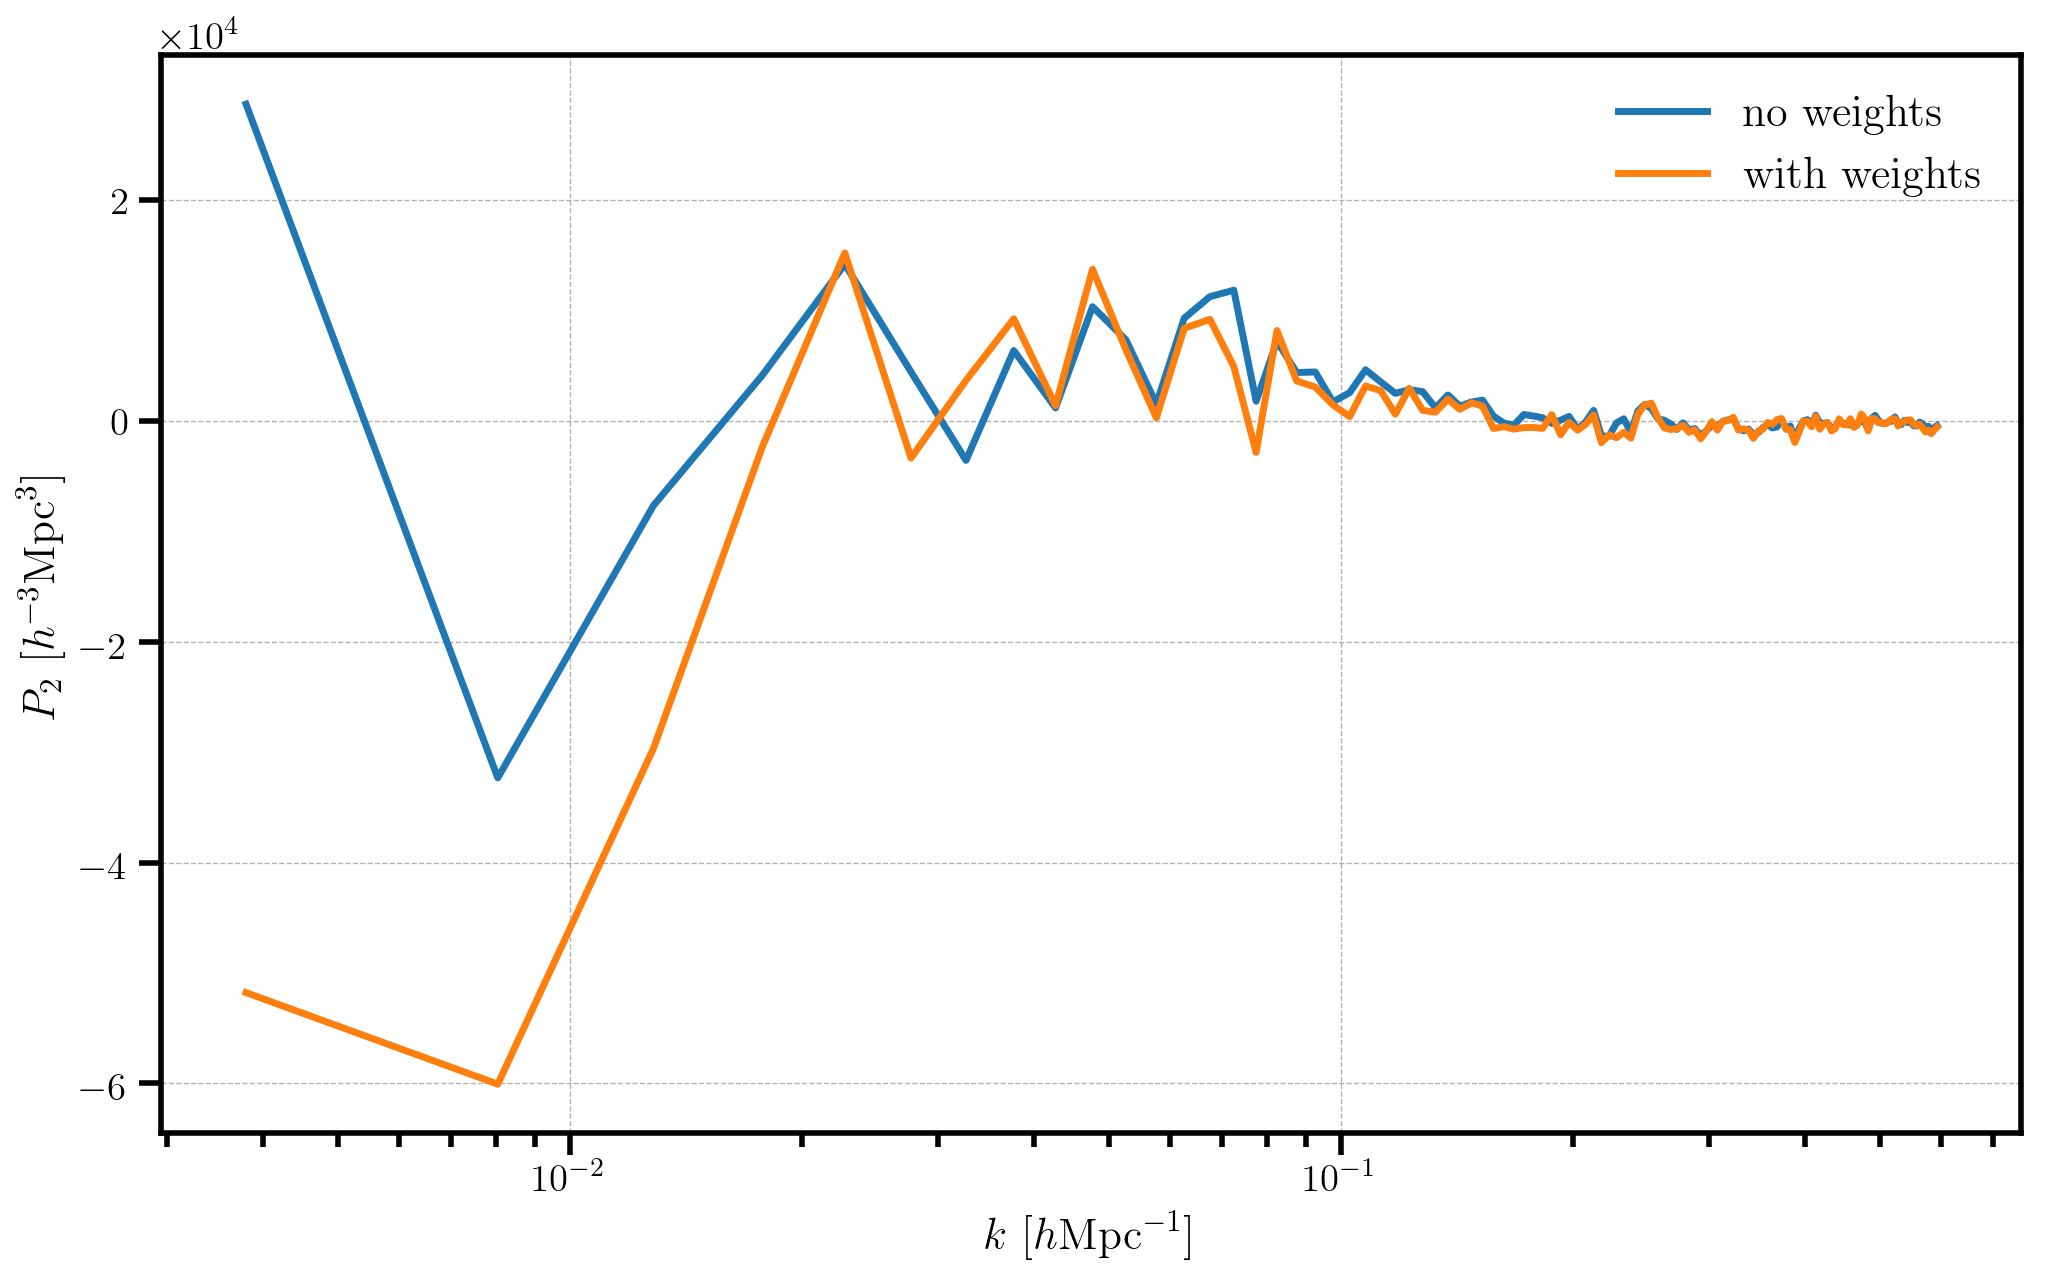

In [18]:
# Quadrupole

labels = ['no weights', 'with weights']
for i, r in enumerate([no_weights_S, P2_weights_S]):
    
    x = r.poles
    plt.semilogx(x['k'], x['power_2'].real, label=labels[i])
    
plt.legend(loc=0)
plt.xlabel(r'$k$ [$h \mathrm{Mpc}^{-1}$]', fontsize=16)
plt.ylabel(r'$P_2$ [$h^{-3} \mathrm{Mpc}^3$]', fontsize=16)

Measured quadrupole from the SGC eBOSS sample with (orange) and without (blue) redshift weights.